# 🥈 Silver Layer: Data Quality & Transformation Pipeline

**Context:** Preparation of Hydrological Time-Series for LSTM Modeling.

---
## 🎯 Objectives
The Silver Layer transforms "Raw" data into "Trusted" data. This pipeline implements strict **Data Quality Gates**:

1.  **Lineage Handling:** The pipeline intelligently processes metadata tags (`data_origin`) inherited from the Bronze Layer.
2.  **Temporal Consistency:** Reindexing to enforce a strict daily calendar (`1994-02-01` to `2024-01-31`).
3.  **Imputation Strategy:** Using **Linear Interpolation**. hydrological data is physically continuous; therefore, linear filling preserves trends better than zero-filling.
4.  **Quality Gates:** Stations with **>10% missing data** are flagged as "High Risk" to prevent model hallucination.
5.  **Storage:** Conversion to **Parquet** (Columnar format) for efficient I/O.

In [107]:
# --- 0. ENVIRONMENT SETUP ---
!pip install -q pandas matplotlib pyarrow fastparquet seaborn

import pandas as pd
import numpy as np
import logging
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from google.colab import drive

# 1. Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
warnings.filterwarnings('ignore')

# 2. Mount Drive
drive.mount('/content/drive', force_remount=True)

# --- 1. CONFIGURATION ---
@dataclass(frozen=True)
class SilverConfig:
    """Immutable Business Rules."""
    # Base Path
    base_path: Path = Path("/content/drive/MyDrive/datalake_simulated")

    # Período da Tese
    start_date: str = '1994-02-01'
    end_date: str = '2024-01-31'
    frequency: str = 'D' # Diário

    # QUALITY GATE: Maximum allowed missing data (10% - Strict Thesis Standard)
    # Estações com mais de 10% de falhas serão marcadas como Risco.
    max_missing_threshold: float = 0.10

# Initialize Paths
config = SilverConfig()
BRONZE_PATH = config.base_path / "raw"
SILVER_PATH = config.base_path / "silver"

# Ensure Directory Structure
for folder in ["flow", "rainfall"]:
    (SILVER_PATH / folder).mkdir(parents=True, exist_ok=True)

print(f"📂 Environment Ready.\nReading from: {BRONZE_PATH}")
print(f"🛡️ Quality Gate Active: Stations with > {config.max_missing_threshold:.0%} missing data will be flagged.")

Mounted at /content/drive
📂 Environment Ready.
Reading from: /content/drive/MyDrive/datalake_simulated/raw
🛡️ Quality Gate Active: Stations with > 10% missing data will be flagged.


## ⚙️ The Transformation Engine
The `SilverTransformer` class orchestrates the lifecycle of the data.

**Key Technical Decisions:**
* **Metadata Separation:** Before performing mathematical operations (interpolation), we isolate the `data_origin` column to prevent type errors.
* **Audit Logging:** Instead of silently fixing data, the system logs the % of missing values for every station.
* **Storage:** We use `fastparquet` engine for optimized writing speed.

## 🚀 Pipeline Execution
Running the transformation for Flow and Rainfall datasets.
**Observe the Logs:** The system will output the Quality Status (`✅ Acceptable` or `🚩 Risk`) for each station based on the 10% threshold.

In [108]:
import re

class SilverTransformer:
    """
    Orchestrates the Raw -> Trusted transformation lifecycle.
    Includes Advanced Column Normalization & Debugging.
    """
    def __init__(self, config: SilverConfig):
        self.config = config
        self.master_calendar = pd.date_range(
            start=self.config.start_date,
            end=self.config.end_date,
            freq=self.config.frequency
        )

    def load_bronze(self, file_path: Path) -> pd.DataFrame:
        if not file_path.exists():
            logging.error(f"❌ File not found: {file_path}")
            return None
        return pd.read_csv(file_path, index_col=0, parse_dates=True)

    def audit_station(self, series: pd.Series, name: str) -> dict:
        total = len(series)
        missing = series.isna().sum()
        pct = missing / total
        return {"name": name, "missing_count": missing, "missing_pct": pct}

    def transform(self, df: pd.DataFrame, context_name: str) -> pd.DataFrame:
        """
        Main Transformation Pipeline with Aggressive Column Sanitization.
        """
        if df is None or df.empty:
            logging.warning(f"⚠️ Empty DataFrame for {context_name}.")
            return df

        # --- 🕵️‍♀️ DEBUG: SHOW ORIGINAL COLUMNS ---
        # Prints exactly what Pandas detects in the raw file for debugging
        logging.info(f"🔍 [DEBUG] Original Columns in {context_name}: {df.columns.tolist()}")

        # --- SANITIZATION (Deep Cleaning) ---
        # 1. Cast column names to string
        df.columns = df.columns.astype(str)
        # 2. Strip whitespace
        df.columns = df.columns.str.strip()
        # 3. Remove '.0' suffix (e.g., '2055003.0' becomes '2055003')
        df.columns = df.columns.str.replace(r'\.0$', '', regex=True)

        # --- 0. BLACKLIST FILTER ---
        # Validate against the sanitized list
        cols_to_drop = [col for col in self.config.exclude_stations if col in df.columns]

        # Fallback: Attempt partial match if exact match fails
        if not cols_to_drop:
             for bad_station in self.config.exclude_stations:
                 for col in df.columns:
                     if bad_station in col: # If '2055003' is a substring of the column name
                         cols_to_drop.append(col)

        # Deduplicate removal list and apply
        cols_to_drop = list(set(cols_to_drop))

        if cols_to_drop:
            logging.info(f"🚫 Blacklist Active: Eliminating {cols_to_drop} from {context_name}")
            df = df.drop(columns=cols_to_drop)
        else:
            logging.info(f"✅ No blacklisted stations found in {context_name}.")

        # --- 1. METADATA HANDLING ---
        df_processing = df.copy()
        if 'data_origin' in df_processing.columns:
            source = df_processing['data_origin'].mode()[0] if not df_processing['data_origin'].mode().empty else 'Unknown'
            logging.info(f"ℹ️ [LINEAGE] Dataset {context_name} sourced from: {source}")
            df_processing = df_processing.drop(columns=['data_origin'])

        # --- 2. DEDUPLICATION ---
        df_processing = df_processing[~df_processing.index.duplicated(keep='first')]

        # --- 3. TEMPORAL ALIGNMENT ---
        df_conformed = df_processing.reindex(self.master_calendar)

        # --- 4. QUALITY AUDIT ---
        for col in df_conformed.columns:
            stats = self.audit_station(df_conformed[col], col)
            if stats['missing_pct'] > self.config.max_missing_threshold:
                logging.warning(f"🚩 Station {col}: {stats['missing_pct']:.1%} missing. EXCEEDS THRESHOLD.")
            else:
                logging.info(f"✅ Station {col}: {stats['missing_pct']:.1%} missing (Acceptable).")

        # --- 5. IMPUTATION ---
        logging.info(f"🔧 Applying Linear Interpolation for {context_name}...")
        df_clean = df_conformed.interpolate(method='linear', limit_direction='both')

        return df_clean.round(2)

    def save_parquet(self, df: pd.DataFrame, folder: str, filename: str):
        output_path = SILVER_PATH / folder / f"{filename}.parquet"
        df.to_parquet(output_path)
        logging.info(f"💾 Saved to Parquet: {output_path}")

## 📈 Data Quality Validation (Post-Processing)
Visual inspection of the **Trusted Data**.
The plots below demonstrate the continuity of the time-series after Linear Interpolation. Gaps have been filled, and the data is now ready for Feature Engineering (Gold Layer).


📈 Generating Technical Reports (Sample of 3 Stations)...


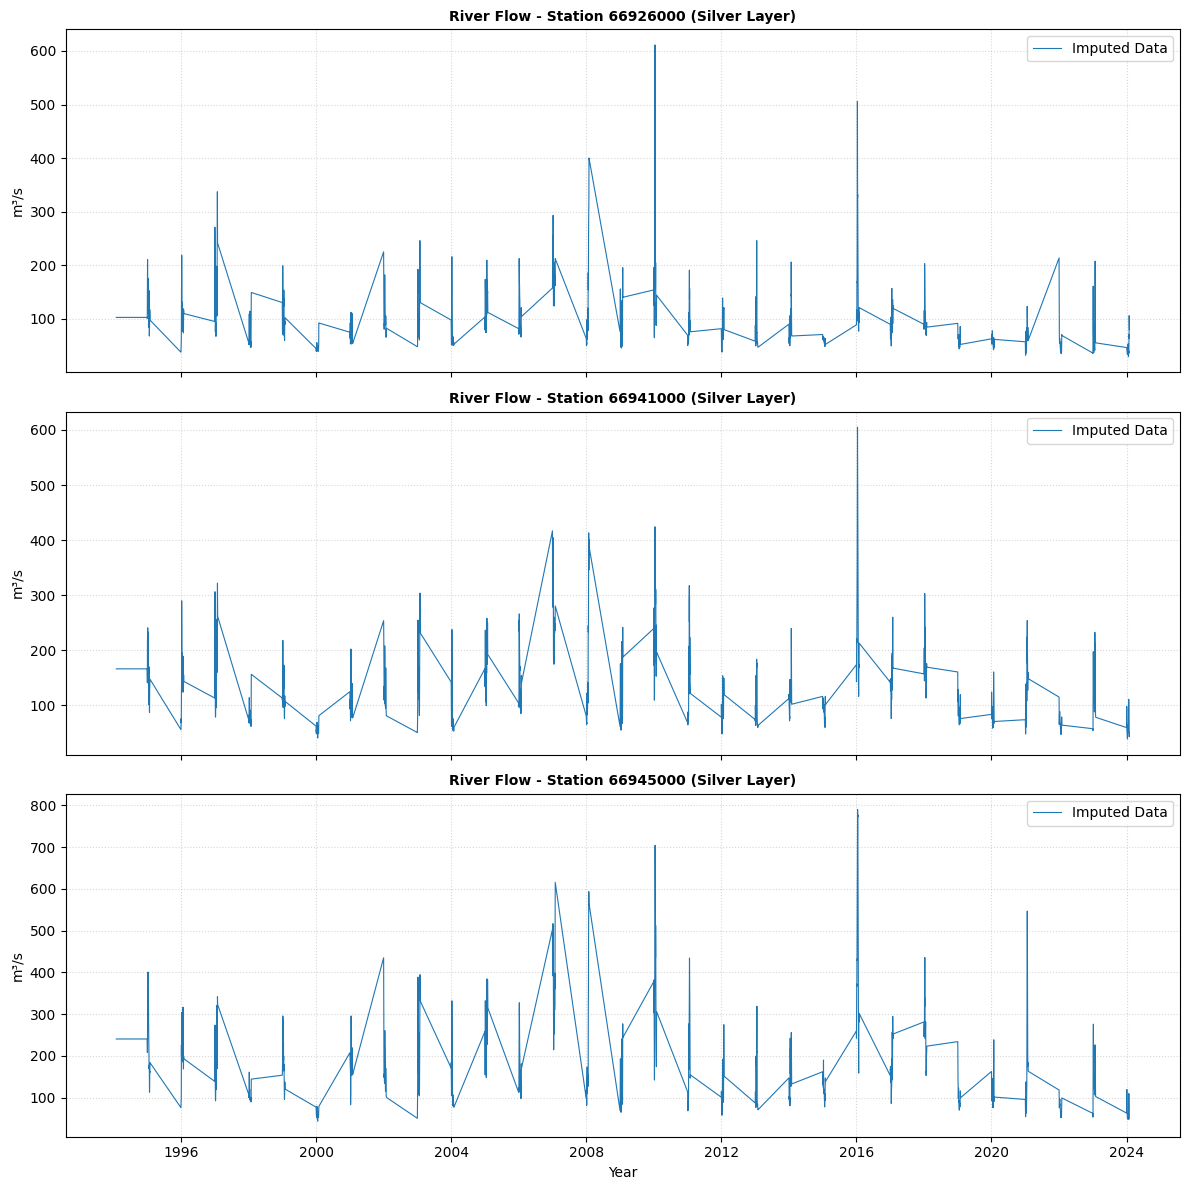

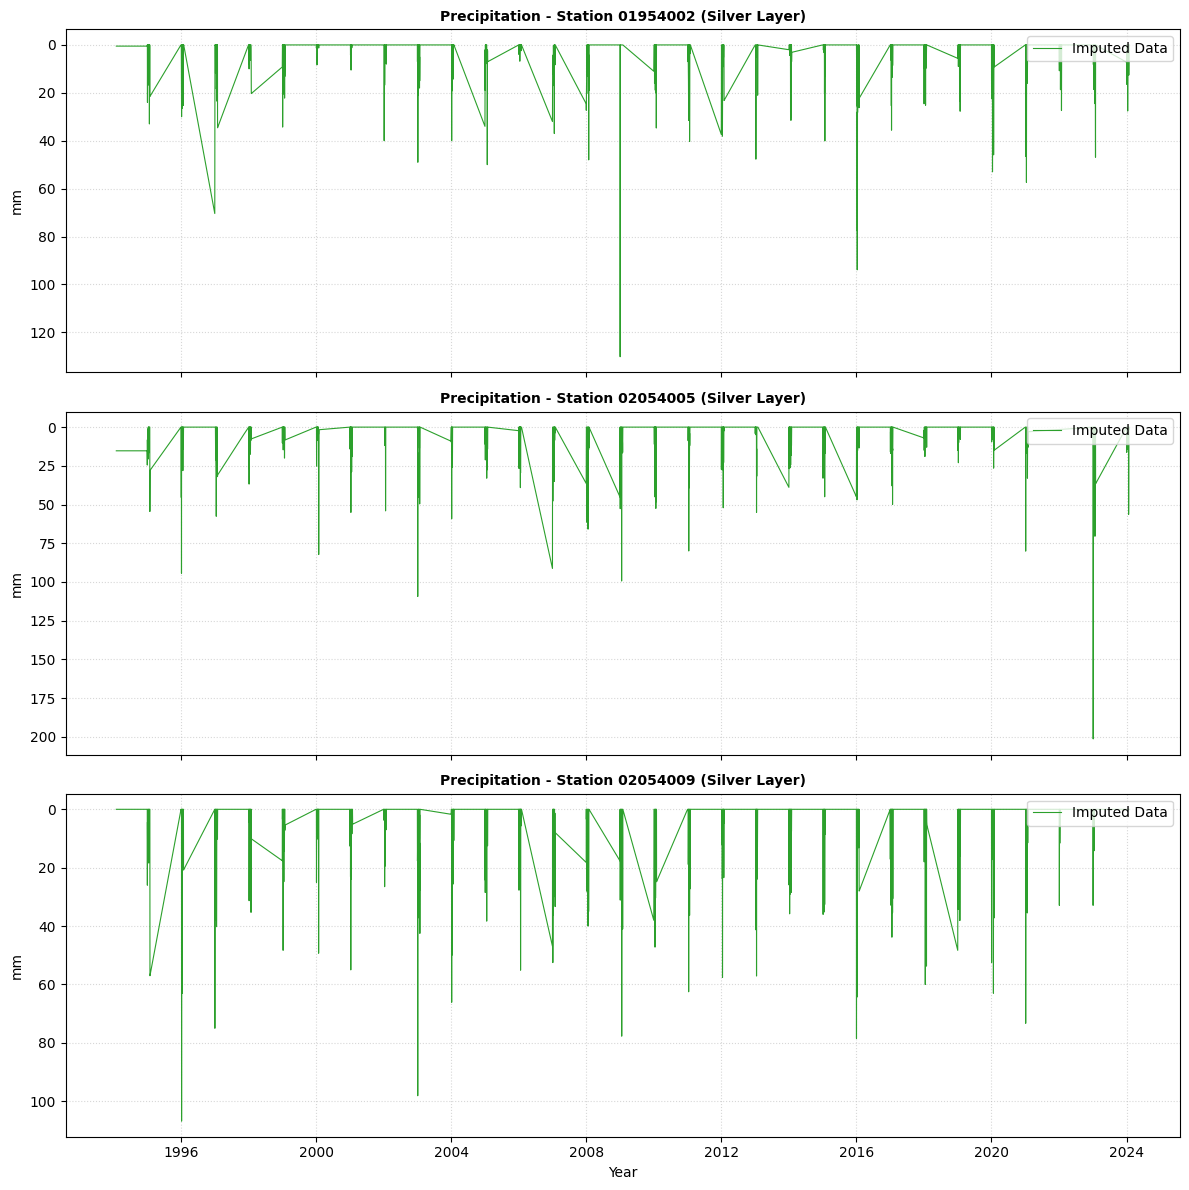

In [109]:
def plot_station_analysis(df, title, unit, base_color):
    """
    Generates a professional time-series plot for a representative sample of stations.
    Limits output to the first 3 stations to avoid report clutter.
    """
    if df is None or df.empty:
        print(f"⚠️ No data for {title}")
        return

    # SELECT ONLY THE FIRST 3 STATIONS
    stations_to_plot = df.columns[:3]
    num_plots = len(stations_to_plot)

    if num_plots == 0: return

    # Create a figure tall enough to fit all subplots (4 inches per plot)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 4 * num_plots), sharex=True)

    # Ensure 'axes' is iterable even if there's only 1 station
    if num_plots == 1:
        axes = [axes]

    for i, station in enumerate(stations_to_plot):
        ax = axes[i]

        # Plot Data
        ax.plot(df.index, df[station], color=base_color, linewidth=0.8, label='Imputed Data')

        # Styling
        ax.set_title(f"{title} - Station {station} (Silver Layer)", fontsize=10, fontweight='bold')
        ax.set_ylabel(unit)
        ax.grid(True, linestyle=':', alpha=0.5)
        ax.legend(loc='upper right')

        # Invert Y-axis for Rainfall (Hydrology standard)
        if "Precipitation" in title or "Rain" in title:
            ax.invert_yaxis()

    plt.xlabel("Year")
    plt.tight_layout()
    plt.show()

print("\n📈 Generating Technical Reports (Sample of 3 Stations)...")

if 'df_flow_silver' in locals():
    # Flow (Blue)
    plot_station_analysis(df_flow_silver, "River Flow", "m³/s", "#1f77b4")

if 'df_rain_silver' in locals():
    # Rainfall (Green)
    plot_station_analysis(df_rain_silver, "Precipitation", "mm", "#2ca02c")